In [1]:
import os
import pandas as pd
import numpy as np
import scipy, sklearn, urllib, librosa, IPython.display as ipd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC 
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor

In [2]:
# load features.csv
df = pd.read_csv('features.csv')
#df.head()


In [3]:
# csv file without filename

features = df.drop(columns=["filename"])
#features.head()


In [4]:
#check number of rows and columns in dataset
features.shape

(1000, 41)

In [5]:
#create a dataframe with all training data except the target column
X = features.drop(columns=["genre"])

In [6]:
#separate target values
y = df["genre"].values


# Logistic Regression

In [7]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=1, stratify=y)

#create knn model
log_reg = LogisticRegression(penalty = 'l2',dual = False,tol= 0.0001, C = 1.0, fit_intercept = True,intercept_scaling = 1,
                             class_weight = None, random_state = 666,  solver = 'liblinear', max_iter = 100, multi_class = 'ovr',
                             verbose = 0, warm_start = False, n_jobs = None)

log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=666, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Random Forest

In [8]:
# train the classifier
rf = RandomForestClassifier()

# dictionary of parameters to test
params_rf = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(X_train, y_train)

rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)

{'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


# XGB

In [9]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# SVM

In [10]:
svclassifier = SVC(kernel='linear')  
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
sv_gs = GridSearchCV(svclassifier, param_grid, cv=5)
sv_gs.fit(X_train, y_train)
   
sv_best = sv_gs.best_estimator_

print(sv_gs.best_params_)

{'C': 0.01, 'gamma': 0.001}


In [11]:
print('rf: {}'.format(rf_best.score(X_test, y_test)))
print('log_reg: {}'.format(log_reg.score(X_test, y_test)))
print('xgb: {}'.format(xgb.score(X_test, y_test)))
print('SVM: {}'.format(sv_best.score(X_test, y_test)))

rf: 0.63
log_reg: 0.67
xgb: 0.725
SVM: 0.68


# Essemble Classifier


In [12]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('xgb', xgb), ('rf', rf_best), ('log_reg', log_reg), ('svclassifier', svclassifier)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [13]:
#fit model to training data
ensemble.fit(X_train, y_train)

# make predictions for test data
y_pred = ensemble.predict(X_test)

#test our model on the test data
ensemble.score(X_test, y_test)

0.71

Text(0.5, 8.5, 'Predicted Label')

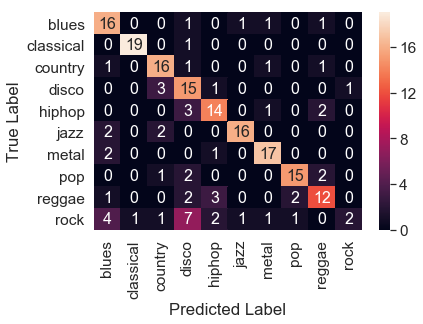

In [14]:
# Confusion Matrix
import seaborn as sn
genres = df["genre"].unique()
cmx = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cmx,genres,genres)
sn.set(font_scale = 1.4)
sn.heatmap(df_cm, annot = True, annot_kws = {"size": 16})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
